# Generating preliminary results for the final aggregation classifier

In [1]:
import os

# Function to change to the parent directory
def change_to_parent_directory():
    # Check if the directory has already been changed
    if not os.environ.get('DIR_CHANGED'):
        try:
            current_dir = os.path.dirname(os.path.abspath(__file__))
        except NameError:
            current_dir = os.getcwd()
        parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
        os.chdir(parent_dir)
        os.environ['DIR_CHANGED'] = '1'
        print(f"Current working directory changed to: {os.getcwd()}")
    else:
        print("Directory has already been changed.")

# Call the function to change the working directory
change_to_parent_directory()

Current working directory changed to: /home/ihranicky/git/domainradar-clf


## Optional: Create testing dataset
Note: If you want do to this, set create_test_parquet to **True**

In [2]:
create_test_parquet = True

if create_test_parquet:
    import pandas as pd
    import numpy as np

    # List of input Parquet files along with their maximum rows and desired labels

    html_input_files = [
        {'file': 'testdata/benign_2312_HTML.parquet', 'label': 'benign', 'max_rows': 150000},
        {'file': 'testdata/phishing_2406_strict_HTML.parquet', 'label': 'phishing', 'max_rows': 24587},
        {'file': 'testdata/malware_2406_strict_HTML.parquet', 'label': 'malware', 'max_rows': 22969},
    ]
    
    nonhtml_input_files = [
        {'file': 'testdata/benign_2312.parquet', 'label': 'benign', 'max_rows': 20000},
        {'file': 'testdata/umbrella_benign_FINISHED.parquet', 'label': 'benign', 'max_rows': 150000},
        {'file': 'testdata/phishing_2406_strict.parquet', 'label': 'phishing', 'max_rows': 100000},
        {'file': 'testdata/malware_2406_strict.parquet', 'label': 'malware', 'max_rows': 100000},
        {'file': 'testdata/lex-dga-830k-pick.parquet', 'label': 'dga', 'max_rows': 100000},
    ]

    ROW_LIMIT = 0  # 0 for no limit

    # Function to load and assign labels to data
    def load_and_label_data(file_info):
        df = pd.read_parquet(file_info['file']).head(file_info['max_rows'])
        df['label'] = file_info['label']  # Explicitly set label
        return df

    # Load HTML-based inputs
    html_combined_df = pd.concat(
        [load_and_label_data(file_info) for file_info in html_input_files], ignore_index=True
    )

    # Ensure `domain_name` is unique in HTML-based data
    html_combined_df = html_combined_df.drop_duplicates(subset='domain_name')

    # Extract HTML-based column structure and data types
    html_columns = html_combined_df.columns.tolist()
    html_dtypes = html_combined_df.dtypes

    # Load non-HTML inputs
    nonhtml_combined_df = pd.concat(
        [load_and_label_data(file_info) for file_info in nonhtml_input_files], ignore_index=True
    )

    # Resolve duplicates: prefer HTML-based data
    nonhtml_combined_df = nonhtml_combined_df[~nonhtml_combined_df['domain_name'].isin(html_combined_df['domain_name'])]

    # Add missing HTML columns to non-HTML data
    missing_html_cols = [col for col in html_columns if col not in nonhtml_combined_df.columns]
    if missing_html_cols:
        missing_defaults = {
            col: (
                -1 if pd.api.types.is_numeric_dtype(html_dtypes[col]) else
                False if pd.api.types.is_bool_dtype(html_dtypes[col]) else
                "" if pd.api.types.is_string_dtype(html_dtypes[col]) else
                pd.Timestamp("1970-01-01") if pd.api.types.is_datetime64_any_dtype(html_dtypes[col]) else
                None
            )
            for col in missing_html_cols
        }
        missing_df = pd.DataFrame({col: [missing_defaults[col]] * len(nonhtml_combined_df) for col in missing_html_cols})
        nonhtml_combined_df = pd.concat([nonhtml_combined_df, missing_df], axis=1)

    # Combine both datasets
    combined_df = pd.concat([html_combined_df, nonhtml_combined_df], ignore_index=True)

    # Ensure no empty or missing labels
    combined_df['label'] = combined_df['label'].fillna("").astype(str)
    invalid_labels = combined_df[combined_df['label'] == ""]
    if not invalid_labels.empty:
        print(f"Warning: Found {len(invalid_labels)} rows with invalid labels. Removing them.")
        combined_df = combined_df[combined_df['label'] != ""]

    # Replace any remaining NaN or None values with -1 or appropriate placeholders
    for col in combined_df.columns:
        if pd.api.types.is_numeric_dtype(combined_df[col]):
            combined_df[col] = combined_df[col].fillna(-1)
        elif pd.api.types.is_bool_dtype(combined_df[col]):
            combined_df[col] = combined_df[col].fillna(False)
        elif pd.api.types.is_string_dtype(combined_df[col]) or pd.api.types.is_object_dtype(combined_df[col]):
            combined_df[col] = combined_df[col].fillna("")
        elif pd.api.types.is_datetime64_any_dtype(combined_df[col]):
            combined_df[col] = combined_df[col].fillna(pd.Timestamp("1970-01-01"))

    # Ensure correct types in the combined DataFrame
    for col in html_columns:
        if col in combined_df.columns:
            if pd.api.types.is_integer_dtype(html_dtypes[col]):
                combined_df[col] = combined_df[col].fillna(-1).astype(int)
            else:
                combined_df[col] = combined_df[col].astype(html_dtypes[col])

    # Subsample the combined dataframe
    if ROW_LIMIT > 0:
        combined_df = combined_df.sample(n=ROW_LIMIT, random_state=42)

    # Shuffle the DataFrame
    shuffled_df = combined_df.sample(frac=1, random_state=42)

    # Save the final combined dataset
    shuffled_df.to_parquet('testdata/decision_training_2411.parquet', engine='pyarrow')
    df = shuffled_df

## Optional: Class balancing

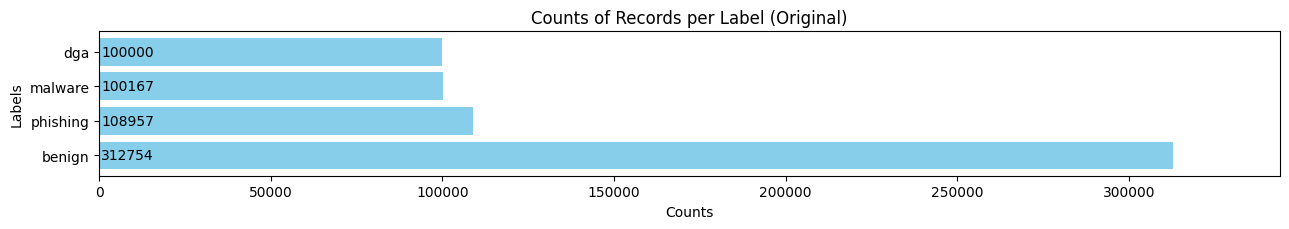

===


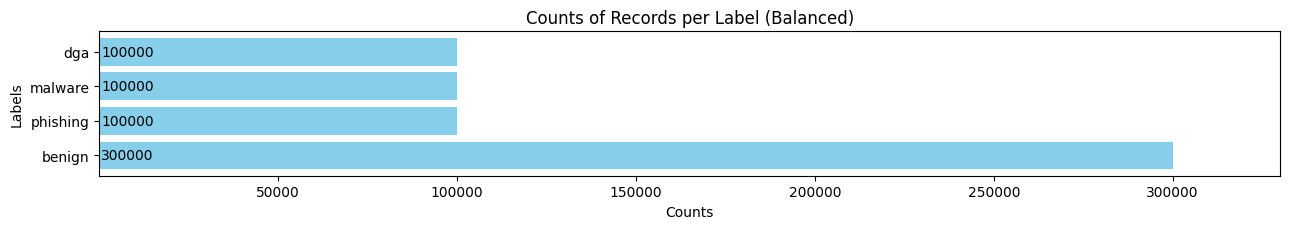

In [3]:
class_balancing = True

if class_balancing:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Step 1: Get the unique values of the label column
    labels = df['label'].unique()

    # Step 2: Get the counts of each label-valued row
    label_counts = df['label'].value_counts()

    # Step 3: Draw a horizontal barplot with textual numbers of records for each label
    plt.figure(figsize=(13, 2.4))  # Adjusted width and height
    plt.barh(label_counts.index, label_counts.values, color='skyblue')
    plt.xlabel('Counts')
    plt.ylabel('Labels')
    plt.title('Counts of Records per Label (Original)')
    for i, v in enumerate(label_counts.values):
        plt.text(500, i, str(v), va='center')  # Move numbers closer to bars
    plt.xlim(0, max(label_counts.values) * 1.1)  # Add buffer to prevent overlap
    plt.tight_layout()
    plt.show()

    print("===")

    # Step 4: Define a dictionary with labels as keys and maximum numbers of rows as values
    max_samples = {
        'benign': 300000,
        'phishing': 100000,
        'malware': 100000,
        'dga': 100000
    }

    # Step 5: Subsample the DataFrame for each label
    subsampled_dfs = []
    for label, max_count in max_samples.items():
        subset = df[df['label'] == label]
        if len(subset) > max_count:
            subset = subset.sample(n=max_count, random_state=42)
        subsampled_dfs.append(subset)

    # Combine the subsampled DataFrames
    balanced_df = pd.concat(subsampled_dfs, ignore_index=True)

    # Step 6: Display the horizontal barplot for the new balanced DataFrame
    new_label_counts = balanced_df['label'].value_counts()
    plt.figure(figsize=(13, 2.4))  # Adjusted width and height
    plt.barh(new_label_counts.index, new_label_counts.values, color='skyblue')
    plt.xlabel('Counts')
    plt.ylabel('Labels')
    plt.title('Counts of Records per Label (Balanced)')
    for i, v in enumerate(new_label_counts.values):
        plt.text(500, i, str(v), va='center')  # Move numbers closer to bars
    plt.xlim(5, max(new_label_counts.values) * 1.1)  # Add buffer to prevent overlap
    plt.tight_layout()
    plt.show()

    # Update parquet:
    balanced_df.to_parquet('testdata/decision_training_2411.parquet', engine='pyarrow')
    df = balanced_df


In [4]:
df

,domain_name,dns_has_dnskey,dns_A_count,dns_AAAA_count,dns_MX_count,dns_NS_count,dns_TXT_count,dns_SOA_count,dns_CNAME_count,dns_zone_level,...,html_num_of_form_js,html_malicious_form,html_most_common,html_num_of_css_internal,html_num_of_css_external,html_num_of_anchors_to_content,html_num_of_anchors_to_void,html_num_of_blank_spaces,html_blocked_keywords_label,label
0,cznet.portal.1tld.biz,0.0,1,0,0,0,0,0,0,0,...,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,benign
1,warjabakti.desa.id,0.0,1,0,1,2,0,1,0,0,...,0,1,0.0,0,0,0,0,3687,0,benign
2,1688.com,0.0,1,0,0,2,3,1,0,0,...,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,benign
3,carfax.auth0.com,0.0,2,2,0,2,0,1,0,1,...,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,benign
4,element.homes,0.0,4,0,1,3,0,1,0,0,...,0,0,0.0,0,0,0,0,280,1,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,xcmfqetilmfkttuw.net,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,dga
599996,owspkjqlvpfrvstp.info,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,dga
599997,jcjjuvxovprjtlhe.biz,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,dga
599998,rnomnguklrdlre.org,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,dga


In [5]:
df.dtypes

domain_name                        object
dns_has_dnskey                    float64
dns_A_count                         int64
dns_AAAA_count                      int64
dns_MX_count                        int64
                                   ...   
html_num_of_anchors_to_content      int64
html_num_of_anchors_to_void         int64
html_num_of_blank_spaces            int64
html_blocked_keywords_label         int64
label                              object
Length: 266, dtype: object

## Generate preliminary results for training the final aggregation classifier

In [6]:
import pandas as pd
import numpy as np
from classifiers.pipeline import Pipeline

# Initialize the classification pipeline
clf = Pipeline()

# Read the input parquet file
input_df = pd.read_parquet('testdata/decision_training_2411.parquet')


# Time measurement start
import time
start_time = time.time()

# DO
preliminary_results_df = clf.generate_preliminary_results(input_df, add_final=False, output_file="preliminary_results_2411.parquet")

# Time measurement stop
end_time = time.time()
elapsed_time_seconds = end_time - start_time
hours = int(elapsed_time_seconds // 3600)
minutes = int((elapsed_time_seconds % 3600) // 60)
seconds = elapsed_time_seconds % 60

print(f"Elapsed time: {hours} hours, {minutes} minutes, {seconds:.2f} seconds")

2024-11-23 18:41:27.337246: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ihranicky/git/domainradar-clf/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CNN model created
Elapsed time: 0 hours, 4 minutes, 15.70 seconds


In [7]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = '{:.6f}'.format
preliminary_results_df

,domain_name,dns_available,dns_nonzero,tls_available,tls_nonzero,ip_available,ip_nonzero,rdap_available,rdap_nonzero,geo_available,geo_nonzero,html_available,html_nonzero,phishing_cnn_result,phishing_lgbm_result,phishing_xgboost_result,phishing_deepnn_result,phishing_dns_nn_result,phishing_rdap_nn_result,phishing_ip_nn_result,phishing_html_lgbm_result,malware_lgbm_result,malware_xgboost_result,malware_deepnn_result,malware_html_lgbm_result,dga_binary_deepnn_result,dga_binary_lgbm_result,phishing_sum,phishing_avg,phishing_prod,malware_sum,malware_avg,malware_prod,dga_binary_sum,dga_binary_avg,dga_binary_prod,total_sum,total_avg,total_prod,label
0,cznet.portal.1tld.biz,0.600000,0.225000,1.000000,0.625000,1.000000,0.500000,0.833333,0.208333,1.000000,0.666667,0.011364,0.011364,0.004618,0.000483,0.000579,0.000248,0.294847,0.000825,0.184353,0.327740,0.000245,0.002364,0.000131,0.356268,0.000000,0.000005,0.813692,0.101711,0.000000,0.359007,0.089752,0.000000,0.000005,0.000002,0.000000,1.172704,0.083765,0.000000,benign
1,warjabakti.desa.id,0.950000,0.625000,0.833333,0.291667,1.000000,0.625000,0.958333,0.541667,1.000000,0.666667,1.000000,0.477273,0.010150,0.000398,0.000410,0.000634,0.032010,0.037507,0.263887,0.104320,0.008038,0.004573,0.001179,0.059969,0.000000,0.000008,0.449318,0.056165,0.000000,0.073758,0.018440,0.000000,0.000008,0.000004,0.000000,0.523085,0.037363,0.000000,benign
2,1688.com,0.950000,0.675000,0.833333,0.250000,1.000000,1.000000,1.000000,0.708333,1.000000,1.000000,0.011364,0.011364,0.033717,0.000254,0.001046,0.000159,0.007333,0.000746,0.063982,0.327740,0.000065,0.002233,0.000001,0.356268,0.010272,0.000150,0.434978,0.054372,0.000000,0.358567,0.089642,0.000000,0.010422,0.005211,0.000002,0.803967,0.057426,0.000000,benign
3,carfax.auth0.com,0.900000,0.600000,0.833333,0.291667,1.000000,0.875000,1.000000,0.833333,1.000000,0.722222,0.011364,0.011364,0.989966,0.006785,0.001525,0.005142,0.981292,0.023718,0.476056,0.327740,0.000079,0.002233,0.000001,0.356268,0.000000,0.000004,2.812222,0.351528,0.000000,0.358581,0.089645,0.000000,0.000004,0.000002,0.000000,3.170807,0.226486,0.000000,benign
4,element.homes,0.950000,0.600000,0.833333,0.291667,1.000000,1.000000,1.000000,0.833333,1.000000,1.000000,1.000000,0.363636,0.000267,0.000278,0.000583,0.000197,0.011078,0.004332,0.031311,0.145919,0.000057,0.002233,0.000000,0.135012,0.000094,0.000001,0.193965,0.024246,0.000000,0.137303,0.034326,0.000000,0.000094,0.000047,0.000000,0.331362,0.023669,0.000000,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,xcmfqetilmfkttuw.net,0.025000,0.000000,0.041667,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.011364,0.011364,1.000000,0.001242,0.000781,0.000000,0.063247,0.000001,0.145029,0.327740,0.020215,0.137096,0.000000,0.356268,0.999928,0.999858,1.538039,0.192255,0.000000,0.513579,0.128395,0.000000,1.999786,0.999893,0.999786,4.051404,0.289386,0.000000,dga
599996,owspkjqlvpfrvstp.info,0.025000,0.000000,0.041667,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.011364,0.011364,1.000000,0.003440,0.017519,0.000000,0.063247,0.000001,0.145029,0.327740,0.019772,0.162735,0.000000,0.356268,1.000000,0.999926,1.556976,0.194622,0.000000,0.538774,0.134694,0.000000,1.999926,0.999963,0.999926,4.095676,0.292548,0.000000,dga
599997,jcjjuvxovprjtlhe.biz,0.025000,0.000000,0.041667,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.011364,0.011364,1.000000,0.001462,0.001653,0.000000,0.063247,0.000001,0.145029,0.327740,0.006561,0.007596,0.000000,0.356268,0.999999,0.999994,1.539132,0.192391,0.000000,0.370425,0.092606,0.000000,1.999993,0.999997,0.999993,3.909550,0.279254,0.000000,dga
599998,rnomnguklrdlre.org,0.025000,0.000000,0.041667,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.011364,0.000000,1.000000,0.001605,0.001697,0.000000,0.063247,0.000001,0.145029,0.327740,0.022390,0.157565,0

In [8]:
preliminary_results_df[["domain_name", "label", "phishing_cnn_result", "phishing_lgbm_result", "phishing_xgboost_result", "phishing_deepnn_result", "phishing_dns_nn_result", "phishing_rdap_nn_result", "phishing_ip_nn_result", "phishing_html_lgbm_result", "malware_lgbm_result", "malware_xgboost_result", "malware_deepnn_result", "malware_html_lgbm_result", "dga_binary_deepnn_result", "dga_binary_lgbm_result"]]

,domain_name,label,phishing_cnn_result,phishing_lgbm_result,phishing_xgboost_result,phishing_deepnn_result,phishing_dns_nn_result,phishing_rdap_nn_result,phishing_ip_nn_result,phishing_html_lgbm_result,malware_lgbm_result,malware_xgboost_result,malware_deepnn_result,malware_html_lgbm_result,dga_binary_deepnn_result,dga_binary_lgbm_result
0,cznet.portal.1tld.biz,benign,0.004618,0.000483,0.000579,0.000248,0.294847,0.000825,0.184353,0.327740,0.000245,0.002364,0.000131,0.356268,0.000000,0.000005
1,warjabakti.desa.id,benign,0.010150,0.000398,0.000410,0.000634,0.032010,0.037507,0.263887,0.104320,0.008038,0.004573,0.001179,0.059969,0.000000,0.000008
2,1688.com,benign,0.033717,0.000254,0.001046,0.000159,0.007333,0.000746,0.063982,0.327740,0.000065,0.002233,0.000001,0.356268,0.010272,0.000150
3,carfax.auth0.com,benign,0.989966,0.006785,0.001525,0.005142,0.981292,0.023718,0.476056,0.327740,0.000079,0.002233,0.000001,0.356268,0.000000,0.000004
4,element.homes,benign,0.000267,0.000278,0.000583,0.000197,0.011078,0.004332,0.031311,0.145919,0.000057,0.002233,0.000000,0.135012,0.000094,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,xcmfqetilmfkttuw.net,dga,1.000000,0.001242,0.000781,0.000000,0.063247,0.000001,0.145029,0.327740,0.020215,0.137096,0.000000,0.356268,0.999928,0.999858
599996,owspkjqlvpfrvstp.info,dga,1.000000,0.003440,0.017519,0.000000,0.063247,0.000001,0.145029,0.327740,0.019772,0.162735,0.000000,0.356268,1.000000,0.999926
599997,jcjjuvxovprjtlhe.biz,dga,1.000000,0.001462,0.001653,0.000000,0.063247,0.000001,0.145029,0.327740,0.006561,0.007596,0.000000,0.356268,0.999999,0.999994
599998,rnomnguklrdlre.org,dga,1.000000,0.001605,0.001697,0.000000,0.063247,0.000001,0.145029,0.327740,0.022390,0.157565,0.000000,0.356268,0.999960,0.999582
